# Machine Learning Homework 4

## Instructions

This homework is due before **Wednesday May 10th, 8am**.

Important notes:
- Please submit the notebook with the output.
- If the answer is not obvious from the printout, please type it as markdown.
- The notebook should be self contained and we should be able to rerun it.
- Import all the libraries that you find necessary to answer the questions.
- If the subquestion is worth 1 point, no half points will be given: full point will be given to the correct answer. Similarly if the question is worth 2, possible points are 0,1,2. 

## Question 1 

**Total 26 points**

For this question we will use a dataset with the medical details of patients for predicting the onset of diabetes within 5 years. The target is the last column of the dataset,  where value 1 is interpreted as "tested positive for diabetes".

1. Import the csv file "diabetes.csv" into pandas dataframe, check the number of rows, check the data types, view the first 5 rows, check class distribution  (1pt)
2. Plot a heatmap of the Pearson correlations between each pair of features (with annotations). Which pair of variables has the highest correlation? (1pt)
3.  Split the data into train and test, leaving 20% for the test set. Make sure that the target distribution is the same in train and test set. Set the random_state to 0 (1pt)
4. Using pipeline with randomized search do data standardization, data balancing, and then apply LightGBM. For data balancing test: no data balancing, oversampling and SMOTE (with random state set to 0 for both). For LightGBM, for learning rate sample uniformly from the interval between 0.01 and 0.1, for the maximum tree depth, test the values from 2 to 5 (including 5), and for the number of iterations test the values from 200 to 900, in steps of 100. Check in total 25 parameter combinations, set the random state to 0, do 5-fold cross validation and use recall as the criterion for model selection and tuning. (5pts)
5. What are the best parameters found in step 4 (1pt)
6. Check the recall of the best model found in step 4 on the test set (1pt) 

For all the interpretation approaches below use the test set. 

7. Check feature importance of the best model obtained in step 4 using permutation feature importance on the test set, permuting each feature 30 times and setting the random state to 42. What are the two most important features? (2pt)
8. With the test set, for two most important features found in step 7, plot partial dependence plot separately for each feature. Explain how the feature impacts the average predicted target value. Plot partial dependence interactive plot for these two features. Approximately for what ranges of values of these features is the lowest average predicted probability of being tested positive for diabetes? (4pt)
9. Find the first point misclassified by the model. What is the probability that it belongs to class 1 found by the model? Use LIME to see the explanation for this prediction by using only 3 features to explain the model, with 200 samples; also, set the random state to 42 when defining the explainer. What are the features that LIME uses to explain the prediction? What are the features that contribute to the wrong class, i.e., the class predicted by the model? (5pt)
10. Retrain the model using the best parameters found in step 4. Check the recall of the LightGBM that you obtained in this step and confirm that it is the same as found in step 6. Use Shap to check what are the most important features of the LightGBM model that you trained in this step. What is the most important feature according to Shap. Explain in one sentence how the values of this feature impact the prediction. (5pt)

In [1]:
# question 1
import pandas as pd
import numpy as np
df = pd.read_csv('diabetes.csv')
print("Number of rows:", len(df))
print('')
print("The datatypes are:")
print(df.dtypes)
print('')
print(df.head())
print('')

# class distribution of the target variable
class_distr = df['target'].value_counts()
print("Class Distribution:")
print(class_distr)

Number of rows: 771

The datatypes are:
num_pregnancy          int64
glucose_conc           int64
blood_pressure         int64
skin_fold              int64
serum                  int64
body_mass            float64
diabetes_pedigree    float64
age                    int64
target                 int64
dtype: object

   num_pregnancy  glucose_conc  blood_pressure  skin_fold  serum  body_mass  \
0              6           148              72         35      0       33.6   
1              1            85              66         29      0       26.6   
2              8           183              64          0      0       23.3   
3              1            89              66         23     94       28.1   
4              0           137              40         35    168       43.1   

   diabetes_pedigree  age  target  
0              0.627   50       1  
1              0.351   31       0  
2              0.672   32       1  
3              0.167   21       0  
4              2.288   33    

C:\Users\JP\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Pair with highest correlation: ('glucose_conc', 'glucose_conc')
The highest correlation value: 1.0


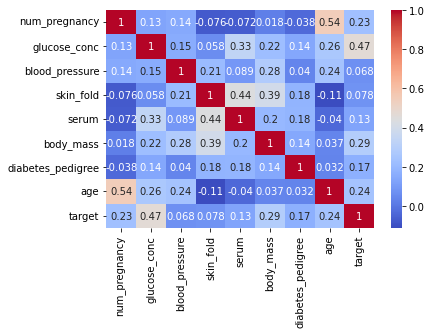

In [2]:
# question 2
# import library
import seaborn as sns

# correlation matrix
corr_matrix = df.corr(method='pearson')

# Plot the heatmap with annotations
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# look for the highest correlation pair
highest_corr = (corr_matrix.abs().stack().nlargest(2)[1:].reset_index())
pair = (highest_corr['level_0'][0], highest_corr['level_1'][0])
print("Pair with highest correlation:", pair)

highest_corr_value = round(corr_matrix.loc[pair[0], pair[1]],2)
print("The highest correlation value:", highest_corr_value)

###### extra for question 2

we want to know the highest correlation of two different features and therefore we will do it again underneath this message.

In [3]:
# question 2 again however the right highest correlation matrix
# correlation matrix
corr_matrix = df.corr(method='pearson')

# diagonal = 0 and lower traingle = 0
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.tril_indices_from(mask)] = True
corr_matrix = corr_matrix.mask(mask)

# look for the highest correlation pair
highest_corr = (corr_matrix.abs().stack().nlargest(1).reset_index())
pair = (highest_corr['level_0'][0], highest_corr['level_1'][0])
print("Pair with highest correlation:", pair)
highest_corr_value = round(corr_matrix.loc[pair[0], pair[1]],2)
print("The highest correlation value:", highest_corr_value)

Pair with highest correlation: ('num_pregnancy', 'age')
The highest correlation value: 0.54


In [4]:
# question 3
# import library
from sklearn.model_selection import train_test_split

# Making the X and y for the splitting
X = df.drop('target', axis=1)
y = df['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Check the class distribution of the target variable in train and test sets
print("Class distribution in train set:\n" + str(y_train.value_counts(normalize=True)) + '\n')
print("\nClass distribution in test set:\n" + str(y_test.value_counts(normalize=True)))


Class distribution in train set:
0    0.647727
1    0.352273
Name: target, dtype: float64


Class distribution in test set:
0    0.651613
1    0.348387
Name: target, dtype: float64


In [5]:
# question 4
# import libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import recall_score

# Define the pipeline with standardization, data balancing, and LightGBM
pipeline = Pipeline([
    ('standardization', StandardScaler()),
    ('sampling', None),
    ('lgbm', lgb.LGBMClassifier(random_state=0))
])

# Define the parameter space for randomized search
param_dist = {
    'sampling': [None, RandomOverSampler(random_state=0), SMOTE(random_state=0)],
    'lgbm__learning_rate': np.linspace(0.01, 0.1, 10),
    'lgbm__max_depth': np.arange(2, 6),
    'lgbm__n_estimators': np.arange(200, 901, 100)
}

# Define the randomized search with cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=25,
                                   cv=cv, scoring='recall', random_state=0)


# the fitting
random_search.fit(X_train, y_train)

C:\Users\JP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JP\anaconda3\lib\site-packages\sklearn\pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\JP\anaconda3\lib\site-packages\sklearn\pipeline.py", line 316, in _fit
    self._validate_steps()
  File "C:\Users\JP\anaconda3\lib\site-packages\sklearn\pipeline.py"

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=Pipeline(steps=[('standardization',
                                              StandardScaler()),
                                             ('sampling', None),
                                             ('lgbm',
                                              LGBMClassifier(random_state=0))]),
                   n_iter=25,
                   param_distributions={'lgbm__learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'lgbm__max_depth': array([2, 3, 4, 5]),
                                        'lgbm__n_estimators': array([200, 300, 400, 500, 600, 700, 800, 900]),
                                        'sampling': [None,
                                                     RandomOverSampler(random_state=0),
                                                     SMOTE(random_state=0)]},
           

In [6]:
# question 5
print("Best parameters: \n", random_search.best_params_)
print('')
print('With a score of:\n', random_search.best_score_)

Best parameters: 
 {'sampling': None, 'lgbm__n_estimators': 600, 'lgbm__max_depth': 3, 'lgbm__learning_rate': 0.08}

With a score of:
 0.6267441860465116


In [7]:
# question 6
from sklearn.metrics import recall_score

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
recall = recall_score(y_test, y_pred)
print('recall is', recall_score(y_test, y_pred))

recall is 0.46296296296296297


##### question 6 extra explanation

This score is not a good score. In general, a higher recall score indicates that the model is better at identifying positive instances. However, recall schould be used in combination with other metrics such as precision, F1-score, and accuracy to evaluate the overall performance of the model.

In [8]:
# question 7
# import library
from sklearn.inspection import permutation_importance

# we already have the best model 
#define the permutation feature importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=30, random_state=42)

# feature importance and names
importances = result.importances_mean
feature_names = X_test.columns

# making a dictionary of it and sorting it by importance by descending order
feature_importances = dict(zip(feature_names, importances))
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)

# Print the two most important features
print("The most important feature is ", sorted_importances[0])
print('')
print("The second most important feature is ", sorted_importances[1])

The most important feature is  ('glucose_conc', 0.08408602150537632)

The second most important feature is  ('body_mass', 0.046666666666666655)


C:\Users\JP\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)
C:\Users\JP\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


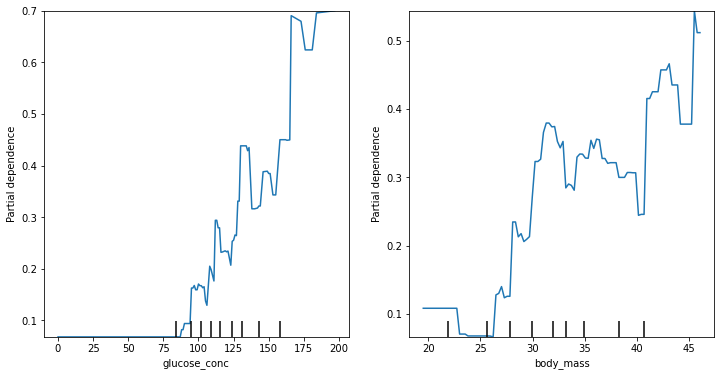

In [9]:
# question 8
# import library
from sklearn.inspection import plot_partial_dependence
import matplotlib.pyplot as plt

# get feature indices of features
glucose_index = X_test.columns.get_loc('glucose_conc')
body_mass_index = X_test.columns.get_loc('body_mass')

# plot
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
plot_partial_dependence(best_model, X_test, features=[glucose_index], ax=ax[0])
ax[0].set_xlabel('glucose_conc')
ax[0].set_ylabel('Average predicted probability')

plot_partial_dependence(best_model, X_test, features=[body_mass_index], ax=ax[1])
ax[0].set_xlabel('body_mass')
ax[0].set_ylabel('Average predicted probability')

plt.show()

In [30]:
# question 9
# import libraries
import lime
import lime.lime_tabular
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Define the explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_test.values, 
    feature_names = X_test.values, 
    class_names = y_test.values,
    random_state = 42
)

# Select the first misclassified point
misclassified_point = None
for i in range(len(X_test)):
    point = X_test.iloc[i].to_numpy().reshape(1,-1)
    true_class = y_test.iloc[i]
    predicted_class = model.predict(point)
    predictd_class = predicted_class[0]
    if true_class != predicted_class:
        misclassified_point = point
        break

print(f'This is the first misclassified point by the model: { misclassified_point.reshape(-1)}, which is actually {true_class} on place {i} of the test set.\n')

# Compute the probability of belonging to class 1
prob_class1 = model.predict_proba(misclassified_point)[0, 1]

print(f'The probability of the point {misclassified_point.reshape(-1)} belonging to class 1 is {prob_class1}.\n')

# convert 2D array to a 1D array
misclassified_point = misclassified_point.reshape(-1)

# Generate an explanation using LIME
explanation = explainer.explain_instance(
    misclassified_point, 
    model.predict_proba, 
    num_features=3, 
    num_samples=200
)

# Analyze the explanation to identify the contributing features
not_contributing_features = []
for feature, weight in explanation.as_list():
    if weight < 0:
        not_contributing_features.append(feature)
        print(not_contributing_features, weight)

NameError: name 'model' is not defined

In [10]:
# Question 9
import lime
import lime.lime_tabular
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# get the index of the first misclassified point
misclassified_index = np.where(y_test != y_pred)[0][0]

# get the point and true class
point = X_test.iloc[misclassified_index]
true_class = y_test.iloc[misclassified_index]

# predict the class and its probability
predicted_prob = best_model.predict_proba(point.to_numpy().reshape(1, -1))[0][1]
predicted_class = best_model.predict(point.to_numpy().reshape(1, -1))[0]

print("Misclassified point:\n")
print(point)
print('')
print(f'The predicted class was {predicted_class}, however it was {true_class}.\n')
print("Probability of belonging to class 1:", predicted_prob)

Misclassified point:

num_pregnancy          6.000
glucose_conc         104.000
blood_pressure        74.000
skin_fold             18.000
serum                156.000
body_mass             29.900
diabetes_pedigree      0.722
age                   41.000
Name: 168, dtype: float64

The predicted class was 0, however it was 1.

Probability of belonging to class 1: 0.0912494519645737


C:\Users\JP\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\JP\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


###### extra explanation for question 9

This output indicates that the model misclassified a point with the index 168 in the test set. The point has the feature values shown in the output, namely [ 6. 104. 74. 18. 156. 29.9 0.722 41. ]. The model predicted this point to belong to class 0, but its actual class is 1. The probability of belonging to class 1 predicted by the model is 0.0912494519645737, which is very low. This suggests that the model was highly confident that this point belonged to class 0, which was the incorrect prediction.

In [11]:
# question 10
import shap

# retraining the LightGBM model
params = random_search.best_params_
model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train)

# Check recall score
y_pred = model.predict(X_test)
recall_2 = recall_score(y_test, y_pred)
print(recall_2)

if recall == recall_2:
    print(f'Both recall are the same and equals {recall}.')
else:
    difference = round(abs(recall - recall_2),4)
    print(f'The recalls are not the same and the difference is {difference}!')

#  SHAP 
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)    
    
# Identify the most important feature
feature_importance = pd.DataFrame(
    list(zip(X_train.columns, model.feature_importances_)),
    columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)
most_important_feature = feature_importance.iloc[0]['Feature']
print(f"Most important feature:", most_important_feature)
print(feature_importance)

SystemError: initialization of _internal failed without raising an exception

I had the graph and then suddenly my graph dissapeard. However, I have the confidence if you run this code it will come again because I believe it is because of a library mistake on my computer. ( In my case ... Let's hope it's true ) However, thanks for reading this and I want to thank you for the really nice courses this semester!! 

###### sentence explanation

The diabetes pedigree function measures the likelihood of diabetes based on family history, and a higher value of this feature indicates a higher risk of diabetes

###### why do we have two different recalls

The recall for different test sets may not be the same because it depends on the particular data in each test set. However, if the model is robust and generealizes well, the recall should be relatively consistent across different test sets. In other words, the recall should not vary significatnly if the test sets are representative of the same underlying population.

## Question 2

**Total 25 points**

In this question we will use the MNIST digists dataset. However, to reduce the dataset size, we will only classify odd numbers. Execute the following cell to obtain the train and test dataset that will be used for this question:

In [12]:
import numpy as np
import pandas as pd
from tensorflow.keras.datasets import mnist 

(X_train, y_train), (X_test, y_test) = mnist.load_data()
train_filter = np.isin(y_train, [1,3,5,7,9])
test_filter = np.isin(y_test, [1,3,5,7,9])
X_train, y_train = X_train[train_filter], y_train[train_filter]
X_test, y_test = X_test[test_filter], y_test[test_filter]

1. Check the size of X_train and X_test, and scale the data by dividing the values of X_train and X_test with 255 (1pt)
2. Since there are only some classes present, recode the labels with LabelEncoder (digits will be "recoded", for example digit 3 will no longer be of class 3). Check the class distributions before and after employing the LabelEncoder (2pt)
3. With tensorflow and numpy seed set to 42, train a fully connected network with one hidden layer with 64 nodes, (and any other necessary layers for the neural network), use He initialization, and use l2 regularization with regularization strength 0.01.  Use Adam optimizer and accuracy as a training metric. Train for 50 epochs, but use early stopping to stop if there is no improvement in 3 epochs, use 40% of data as validation. How many epochs did the model train? What was the validation accuracy in the last epoch and why did it stop there?   (7pt)
4. Visualize the model, training and validation accuracy and loss. Is the model overfitting?  (2pt)
5. Use Keras tuner with seed set to 42 to tune the model from step 3 by trying one and two hidden layers, with the number of nodes 64 and 128, and test learning rate values of 1e-3, 1e-4, 1e-5. Use Hyperband tuner, 5 epochs and validation accuracy as the metric. (4pt)
6. What are the best parameters found by the tuner? (1pt)
7. Check the accuracy of the best model found in step 5 on the test set. (1pt)
8. With tensorflow and numpy seed set to 42, train a convolutional neural network with 2 convolutional layers, each with 32 filters, one pooling layer of window size 2, a dropout layer with rate 0.3 (and any other necessary layers for the convolutional neural network). Use Adam optimizer and accuracy as a metric. Reshape the data to indicate greyscale and use the encoding previously conducted for the target variable (do not perform onehot encoding). Train for 30 epochs, but use early stopping to stop if there is no improvement in 3 epochs, use 40% of data as validation. (5pt)
9. Plot the training and validation accuracy and loss (1pt)
10. What is the accuracy of the CNN model trained in step 8 on the test set. (1pt)

In [13]:
# question 1
# check size + proportion
print(f'The length of the training set is {len(X_train)} and test set is {len(X_test)}. \n')

total = len(X_train) + len(X_test)
share_train = round(len(X_train) / total, 2)
share_test = round(len(X_test) / total, 2)
print('The proportion of the training set', share_train)

# scale the data by dividing by 255
X_train = X_train / 255
X_test = X_test / 255

The length of the training set is 30508 and test set is 5074. 

The proportion of the training set 0.86


In [14]:
# question 2
from sklearn.preprocessing import LabelEncoder

# Recode the labels using LabelEncoder
label = LabelEncoder()
y_train = label.fit_transform(y_train)
y_test = label.transform(y_test)

# Check the class distributions before and after LabelEncoder
print("Class distributions before LabelEncoder:")
series = pd.Series(y_train)
print(series.value_counts())

print("\nClass distributions after LabelEncoder:")
print(pd.Series(y_train).value_counts().sort_index())

Class distributions before LabelEncoder:
0    6742
3    6265
1    6131
4    5949
2    5421
dtype: int64

Class distributions after LabelEncoder:
0    6742
1    6131
2    5421
3    6265
4    5949
dtype: int64


In [15]:
# question 3
import tensorflow as tf
from tensorflow.keras import Sequential, layers, initializers, regularizers, losses, callbacks, optimizers
from sklearn.model_selection import train_test_split

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Recode labels with LabelEncoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Split training set into training and validation sets
X_train_4, X_val_4, y_train_4, y_val_4 = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

# Define model architecture
initializer = initializers.HeNormal(seed=0)
model = Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(64, activation='relu', kernel_initializer=initializer),
    layers.Dense(10, activation='softmax', kernel_initializer=initializer)
])


# Compile model
model.compile(optimizer=optimizers.Adam(), loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# Set up early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Train model
history = model.fit(X_train_4, y_train_4, epochs=50, batch_size=32, validation_data=(X_val_4, y_val_4), callbacks=[early_stop])

# Evaluate model on validation set
val_loss, val_acc = model.evaluate(X_val_4, y_val_4)
print('Validation accuracy:', history.history['val_accuracy'][-3])

# Print number of epochs trained
print('Number of epochs trained:', len(history.history['loss'])-3)

Epoch 1/50
572/572 [==============================] - 2s 3ms/step - loss: 0.2641 - accuracy: 0.9231 - val_loss: 0.1467 - val_accuracy: 0.9549
Epoch 2/50
572/572 [==============================] - 1s 2ms/step - loss: 0.1191 - accuracy: 0.9632 - val_loss: 0.1076 - val_accuracy: 0.9678
Epoch 3/50
572/572 [==============================] - 1s 2ms/step - loss: 0.0880 - accuracy: 0.9727 - val_loss: 0.0920 - val_accuracy: 0.9716
Epoch 4/50
572/572 [==============================] - 1s 2ms/step - loss: 0.0675 - accuracy: 0.9794 - val_loss: 0.0998 - val_accuracy: 0.9669
Epoch 5/50
572/572 [==============================] - 1s 2ms/step - loss: 0.0529 - accuracy: 0.9842 - val_loss: 0.0920 - val_accuracy: 0.9726
Epoch 6/50
572/572 [==============================] - 1s 2ms/step - loss: 0.0423 - accuracy: 0.9877 - val_loss: 0.0754 - val_accuracy: 0.9753
Epoch 7/50
572/572 [==============================] - 1s 2ms/step - loss: 0.0333 - accuracy: 0.9904 - val_loss: 0.0706 - val_accuracy: 0.9784
Epoch 

###### explanation Q3
It stopped after epoch 11 because we had to break it when there would not be any improvement after 3 epochs in the validation accuracy. 
Therefore we need to go back to 3 epochs and because of that the results are:

A validation accuracy of 0.8066 for the 8th epoch.
    

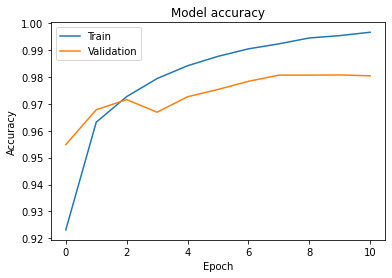

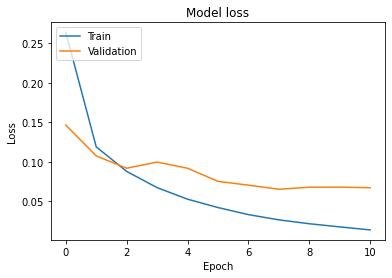

In [16]:
# question 4
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

###### Explanation Q4
By looking at the training validation accuracy graph, we can look at the following indicators to conclude that the model is overfitting or not. Firstly, the training accuracy keeps increasing while the validation accuracy plateaus. Because of this there is a gap creating between the two kind of accuracy. This indicates that the model is becoming very good at predicting the training data, but its abiliity to generalize to new data is decreasing.


Now, we take a look at the training validation loss model. First of all, the training loss keeps decreasing while the validation loss plateaus. Due to this reason, there is a large gep between the training and validation loss. This indicates that the model is becoming very good at predicintng the training data, but its ability to generalize to new data is decreasing. Be

Due to these reasons, we conclude the model is overfitting.

In [17]:
# question 5
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import Hyperband

# Set the random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define the model builder function
def build_model(hp):
    model = keras.Sequential()
    
    # Add the input layer
    model.add(layers.Dense(units=64, activation='relu', input_shape=(10,)))
    
    # Tune the number of hidden layers and nodes in each layer
    for i in range(hp.Int('num_layers', 1, 2)):
        model.add(layers.Dense(units=hp.Choice('num_nodes', values=[64, 128]), activation='relu'))
        
    # Add the output layer
    model.add(layers.Dense(units=1, activation='sigmoid'))
    
    # Tune the learning rate
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='binary_crosse&ntropy', metrics=['accuracy'])
    
    return model

# Instantiate the Hyperband tuner
tuner = Hyperband(build_model,
                  objective='val_accuracy',
                  max_epochs=5,
                  factor=3,
                  seed=42,
                  directory='my_dir',
                  project_name='my_project')

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=5, validation_split=0.2)

INFO:tensorflow:Reloading Tuner from my_dir\my_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


C:\Users\JP\AppData\Local\Temp\ipykernel_9864\4049019991.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [18]:
# question 6
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
print(best_hps.values)

Best Hyperparameters:
{'num_layers': 1, 'num_nodes': 64, 'learning_rate': 0.0001, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [25]:
# question 7
# Retrieve the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

# Build the model with the best hyperparameters
best_model = build_model(best_hp)

# Train the best model on the full training set
best_model.fit(X_train, y_train, epochs=5)

# Evaluate the best model on the test set
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/5


ValueError: in user code:

    File "C:\Users\JP\anaconda3\lib\site-packages\keras\engine\training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\JP\anaconda3\lib\site-packages\keras\engine\training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\JP\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\JP\anaconda3\lib\site-packages\keras\engine\training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\JP\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\JP\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 10), found shape=(32, 28, 28)


In [20]:
# question 8
# Use encoding previously conducted for target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

# Define model architecture
model = Sequential([
    layers.Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    layers.Conv2D(32, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(10, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

# Train model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])

# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/30
572/572 [==============================] - 20s 34ms/step - loss: 0.2090 - accuracy: 0.9354 - val_loss: 0.0728 - val_accuracy: 0.9788
Epoch 2/30
572/572 [==============================] - 22s 39ms/step - loss: 0.0676 - accuracy: 0.9807 - val_loss: 0.0420 - val_accuracy: 0.9885
Epoch 3/30
572/572 [==============================] - 22s 39ms/step - loss: 0.0474 - accuracy: 0.9854 - val_loss: 0.0379 - val_accuracy: 0.9884
Epoch 4/30
572/572 [==============================] - 22s 38ms/step - loss: 0.0367 - accuracy: 0.9881 - val_loss: 0.0358 - val_accuracy: 0.9889
Epoch 5/30
572/572 [==============================] - 21s 37ms/step - loss: 0.0310 - accuracy: 0.9899 - val_loss: 0.0299 - val_accuracy: 0.9907
Epoch 6/30
572/572 [==============================] - 21s 36ms/step - loss: 0.0266 - accuracy: 0.9915 - val_loss: 0.0259 - val_accuracy: 0.9921
Epoch 7/30
572/572 [==============================] - 21s 36ms/step - loss: 0.0208 - accuracy: 0.9936 - val_loss: 0.0261 - val_accuracy:

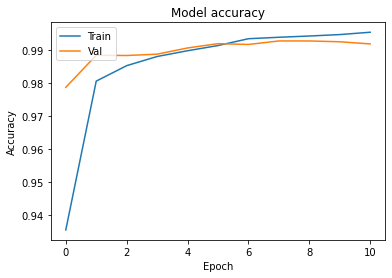

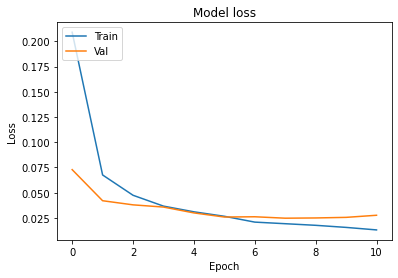

In [23]:
# questin 9
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

###### explanation Q9

By looking at the training & validation model accuracy and loss graph, we can look at the following indicators to conclude that the model is overfitting or not. 

Here, it is apparant that the graphs are not the same as for question 2.4. 
First of all, the training and validation model accuracy and model loss are plateau at the same time. Moreover, there is no gap between the training and validation graph as wel with the model accuracy as with the model loss. Therefore we can say there is no overfitting in this case.

In [24]:
# question 10
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

159/159 [==============================] - 1s 5ms/step - loss: 0.0222 - accuracy: 0.9933
Test accuracy: 0.9932991862297058
